# **Rejection Evaluation**
***

we trained resnet18 on the BUSI dataset using different scoring methods. The output is a csv file containing the scores. let's have a look at it:

In [1]:
import pandas as pd

# output_path = r"C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\outputs\BUSI\resnet18\dropout_all_layers_autolr_longer\seed_55\failure_detection\scores_df.csv"
# output_path = r"C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\outputs\OrganAMNIST\resnet18\dropout_all_layers_autolr\seed_55\failure_detection\scores_df.csv"
output_path = r"C:\Computer_Vision\Medical_Images_With_Rejection\OurSolution\failure_detection_benchmark\outputs\RSNAPneumonia\resnet50\dropout_all_layers_autolr_paper\seed_55\failure_detection\scores_df.csv"
scores_df = pd.read_csv(output_path)
scores_df.head()

,Targets,Predictions,IsCorrect,Probas,Threshold,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,...,Laplace_threshold,Laplace_score,Laplace_probas,TrustScore,ConfidNet_scores,SWAG_probas,SWAG_targets,SWAG_predictions,SWAG_threshold,SWAG_score
0,0,False,True,0.069185,0.256104,0.930815,-0.147838,0.910226,False,0.089774,...,0.270832,0.910820,0.089180,1.170258,0.883999,0.202565,0,False,0.365878,0.797435
1,0,False,True,0.042340,0.256104,0.957660,-0.088250,0.966602,False,0.033398,...,0.270832,0.931371,0.068629,1.159251,0.929127,0.047159,0,False,0.365878,0.952841
2,0,False,True,0.119516,0.256104,0.880484,-0.266567,0.880902,False,0.119098,...,0.270832,0.855339,0.144661,1.575550,0.786745,0.091072,0,False,0.365878,0.908928
3,0,False,True,0.020617,0.256104,0.979383,-0.042083,0.975860,False,0.024140,...,0.270832,0.956010,0.043990,1.306924,0.963050,0.058561,0,False,0.365878,0.941439
4,1,True,True,0.501353,0.256104,0.501353,-0.999985,0.450166,True,0.450166,...,0.270832,0.501297,0.501297,1.012178,0.499037,0.400292,1,True,0.365878,0.400292


We can see that the classes were encoded as 0,1,2. In general, normal is encoded as 0, benign is encoded as 1 and malignant is encoded as 2.
The dataframe consists of the following columns:
* Targets - Our GT classes.
* Predictions - The predicted classes
* IsCorrect - Is that classification correct or not?
* Baseline - Baseline softmax scorer.
* doctor_alpha - It is a scorer that quantifies the likelihood of being misclassified , and thus negative (as stated in the article).
* mcmc-soft-scores, mcmc-entropy scores - From the paper: "MC-dropout (MC): Gal & Ghahramani (2016) showed that training a neural network with dropout
regularization (Srivastava et al., 2014) produces a Bayesian approximation of the posterior, where the
approximation is obtained by Monte-Carlo sampling of the network’s parameters i.e. by applying
dropout at test-time and averaging the outputs over several inference passes. The confidence in
the prediction can then be approximated by the negative entropy of the outputs; or by taking the
softmax confidence score on the averaged outputs."
* mcmc predictions - predictions made by using Monte-Carlo sampling on the network's parameters.
* mcmc_probas - probabilities of the predictions for monte-carlo sampling (We can notice that it contains NaN values, we might consider dropping it).
* Laplace_targets - The targets for the laplace method. They are the same as the general targets.
* Laplace predictions - predictions made by Laplace
* Laplace score -Laplace confidence score
* TrustScore - Score made by TrustScore scorer.
* ConfidNet score- scores made by ConfidNet
* SWAG_targets - targets for SWAG method. The same as the general targets.
* SWAG_predictions - The predictions made by SWAG
* SWAG_score - SWAG confidence scores

We used The Baseline scorer, doctor-alpha, MC- softmax, MC- entropy, Laplace, TrustScore, ConfidNet, and SWAG (8 overall). The ones missing (as compared to the paper) are DUQ (which we failed to train due to insufficient CUDA memory) and ensemble (we used only 1 seed so ensemble is irrelevant).


Let's focus on that mcmc_probas column. let's check how many missing values it has:

In [2]:
# print(f'{scores_df["mcmc_probas"].isna().sum() / len(scores_df["mcmc_probas"]) * 100} % missing values in mcmc_probas column')

Since all values in this column are missing, we will just drop it:

In [3]:
# scores_df = scores_df.drop(columns=['mcmc_probas'])
# scores_df.head()

Let's check for missing values once again:

In [2]:
print(f'{scores_df.isna().sum().sum() / scores_df.shape[0] * 100} % missing values in the dataframe')

0.0 % missing values in the dataframe


## **Thresholding**
***

Now that we have no missing values in the dataframe, we can find thresholds for separating the correct classifications from the incorrect ones, for each class and scoring method:

KeyboardInterrupt: 

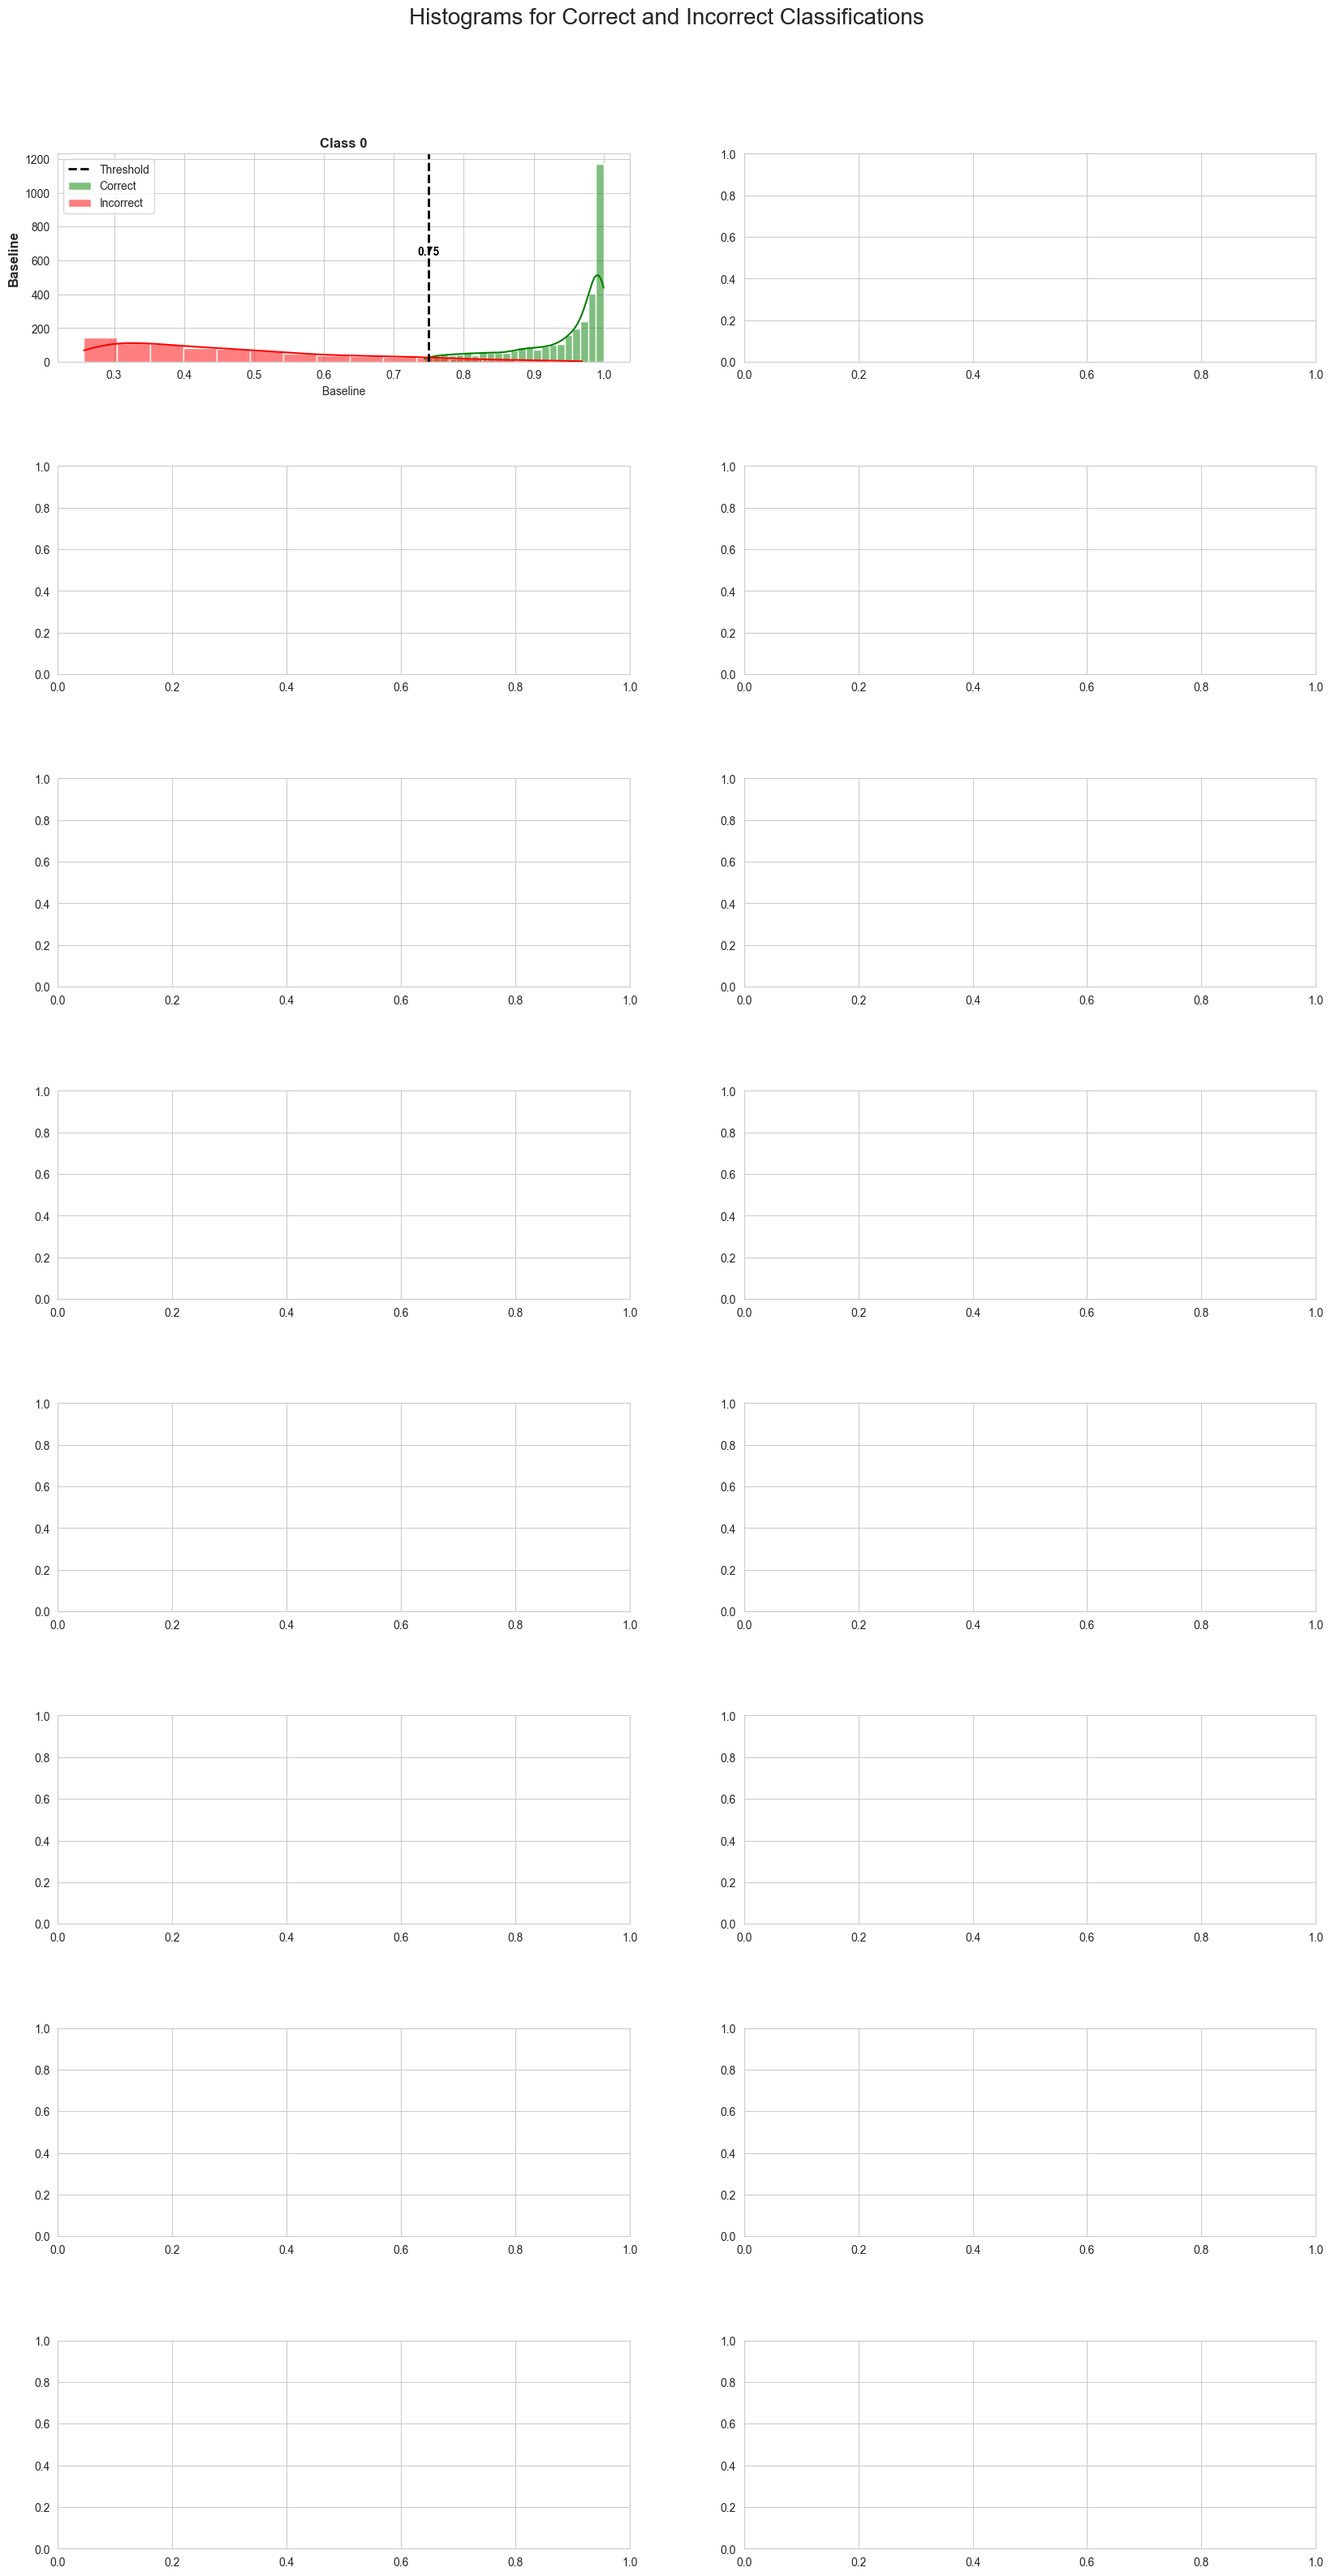

In [5]:
# Necessary Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring methods
scoring_methods = [
    'Baseline', 'doctor_alpha', 'mcmc_soft_scores', 'mcmc_entropy_scores',
    'Laplace_score', 'TrustScore', 'ConfidNet_scores', 'SWAG_score'
]

# Extract unique classes from the dataframe
classes = sorted(scores_df["Targets"].unique())

# Create a figure with 8 rows and 3 columns (8 scoring methods x 3 classes)
fig, axes = plt.subplots(nrows=len(scoring_methods), ncols=len(classes), figsize=(20, 36))  # Increased figsize

fig.subplots_adjust(top=0.93,hspace=0.5)  # Adjust top to create space for the suptitle

# Add suptitle above the subplots
plt.subplots_adjust(top=0.93, hspace=0.5)  # Adjust overall top margin and add blank space with hspace
fig.suptitle('Histograms for Correct and Incorrect Classifications', fontsize=20, y=0.98)

thresholds = {}

for row, method in enumerate(scoring_methods):
    for col, cls in enumerate(classes):
        # Get the appropriate axis for this subplot
        ax = axes[row, col]

        # Separate the data into correct and incorrect classifications for the current class and scoring method
        correct = scores_df[(scores_df['Targets'] == cls) & (scores_df['IsCorrect'] == True)][method]
        incorrect = scores_df[(scores_df['Targets'] == cls) & (scores_df['IsCorrect'] == False)][method]

        # Find the optimal threshold using KDE without clearing histograms
        x_vals = np.linspace(min(scores_df[method]), max(scores_df[method]), 1000)

        if len(correct) >= 2:
            correct_kde = sns.kdeplot(correct, ax=ax).get_lines()[0].get_data()
        else:
            correct_kde = None

        if len(incorrect) >= 2:
            incorrect_kde = sns.kdeplot(incorrect, ax=ax).get_lines()[1].get_data()

        else:
            incorrect_kde = None

        ax.clear()

        # Plot histograms
        sns.histplot(correct, kde=True, color='green', label='Correct', ax=ax)
        sns.histplot(incorrect, kde=True, color='red', label='Incorrect', ax=ax)

        correct_interp = None
        incorrect_interp = None

        if correct_kde is not None:
            correct_interp = np.interp(x_vals, correct_kde[0], correct_kde[1])

        if incorrect_kde is not None:
            incorrect_interp = np.interp(x_vals, incorrect_kde[0], incorrect_kde[1])


        if correct_interp is not None and incorrect_interp is not None:
            overlap_vals = np.minimum(correct_interp, incorrect_interp)
            total_overlap_area = np.trapz(overlap_vals, x_vals)  # Compute area of overlap using np.trapz

            thresholds[(method, cls)] = x_vals[np.argmax(overlap_vals)]  # Minimizes overlap

            # Add threshold to the plot
            threshold = thresholds[(method, cls)]
            ax.axvline(x=threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
            ax.text(threshold, 0.5 * ax.get_ylim()[1], f'{threshold:.2f}', color='black', fontsize=10, ha='center', va='bottom', fontweight='bold')

        # Set titles and labels
        if col == 0:
            ax.set_ylabel(method, fontsize=12, fontweight='bold')
        if row == 0:
            ax.set_title(f'Class {cls}', fontsize=12, fontweight='bold')

        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])    # Ensures better layout of the plots
plt.show()

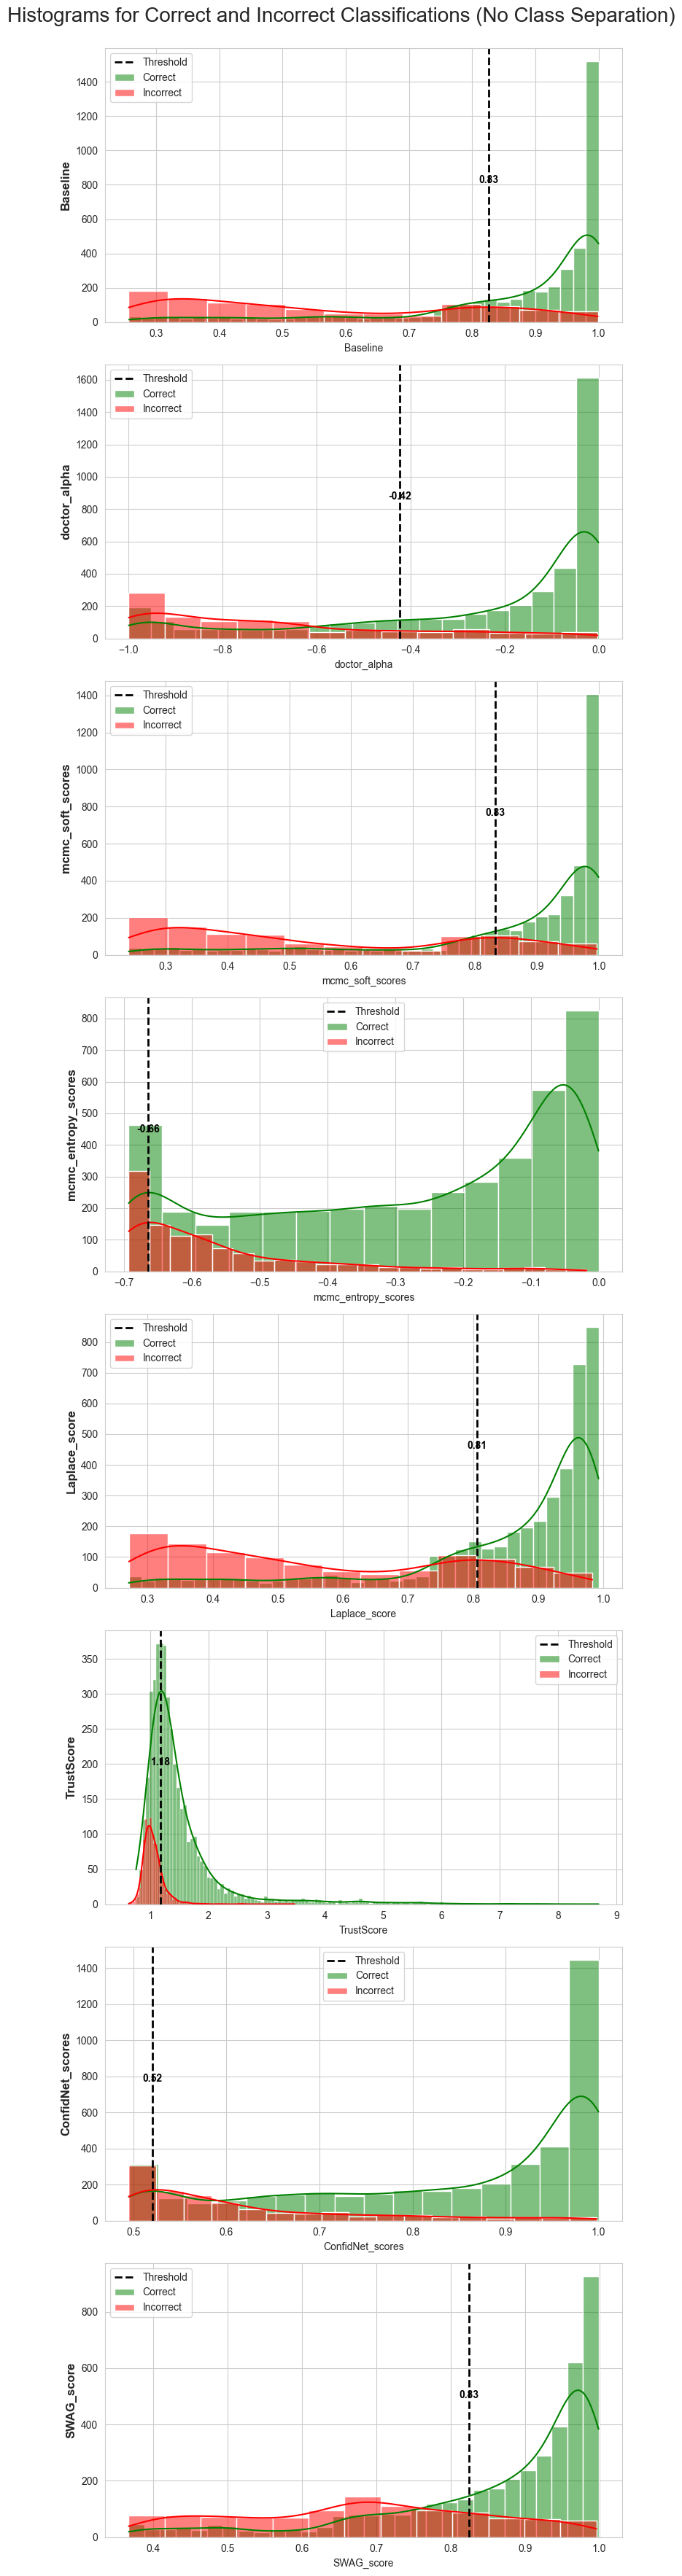

In [13]:
# Necessary Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define scoring methods
scoring_methods = [
    'Baseline', 'doctor_alpha', 'mcmc_soft_scores', 'mcmc_entropy_scores',
    'Laplace_score', 'TrustScore', 'ConfidNet_scores', 'SWAG_score'
]

# Create a figure with 8 rows and 1 column (8 scoring methods)
fig, axes = plt.subplots(nrows=len(scoring_methods), ncols=1, figsize=(8, 36))

fig.subplots_adjust(top=0.93, hspace=0.5)  # Adjust top to create space for the suptitle

# Add suptitle above the subplots
fig.suptitle('Histograms for Correct and Incorrect Classifications (No Class Separation)', fontsize=20, y=0.98)

thresholds = {}

for row, method in enumerate(scoring_methods):
    # Get the appropriate axis for this subplot
    ax = axes[row]

    # Separate the data into correct and incorrect classifications for the current scoring method
    correct = scores_df[scores_df['IsCorrect'] == True][method]
    incorrect = scores_df[scores_df['IsCorrect'] == False][method]

    # Find the optimal threshold using KDE without clearing histograms
    x_vals = np.linspace(min(scores_df[method]), max(scores_df[method]), 1000)

    if len(correct) >= 2:
        correct_kde = sns.kdeplot(correct, ax=ax).get_lines()[0].get_data()
    else:
        correct_kde = None

    if len(incorrect) >= 2:
        incorrect_kde = sns.kdeplot(incorrect, ax=ax).get_lines()[1].get_data()
    else:
        incorrect_kde = None

    ax.clear()

    # Plot histograms
    sns.histplot(correct, kde=True, color='green', label='Correct', ax=ax)
    sns.histplot(incorrect, kde=True, color='red', label='Incorrect', ax=ax)

    correct_interp = None
    incorrect_interp = None

    if correct_kde is not None:
        correct_interp = np.interp(x_vals, correct_kde[0], correct_kde[1])

    if incorrect_kde is not None:
        incorrect_interp = np.interp(x_vals, incorrect_kde[0], incorrect_kde[1])

    if correct_interp is not None and incorrect_interp is not None:
        overlap_vals = np.minimum(correct_interp, incorrect_interp)
        total_overlap_area = np.trapz(overlap_vals, x_vals)  # Compute area of overlap using np.trapz

        thresholds[method] = x_vals[np.argmax(overlap_vals)]  # Minimizes overlap

        # Add threshold to the plot
        threshold = thresholds[method]
        ax.axvline(x=threshold, color='black', linestyle='dashed', linewidth=2, label='Threshold')
        ax.text(threshold, 0.5 * ax.get_ylim()[1], f'{threshold:.2f}', color='black', fontsize=10, ha='center', va='bottom', fontweight='bold')

    # Set titles and labels
    ax.set_ylabel(method, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Ensures better layout of the plots
plt.show()

In [6]:
# Identify rows where the values of 'Targets' and 'SWAG_targets' differ
swag_inconsistent_rows = scores_df[
    scores_df["Targets"] != scores_df["SWAG_targets"]
]

# Identify rows where the values of 'Targets' and 'Laplace_targets' differ
laplace_inconsistent_rows = scores_df[
    scores_df["Targets"] != scores_df["Laplace_targets"]
]

# Print rows where 'SWAG_targets' differ from 'Targets'
print("Rows where 'SWAG_targets' differ from 'Targets':")
display(swag_inconsistent_rows)

# Print rows where 'Laplace_targets' differ from 'Targets'
print("\nRows where 'Laplace_targets' differ from 'Targets':")
laplace_inconsistent_rows

Rows where 'SWAG_targets' differ from 'Targets':


,Targets,Predictions,IsCorrect,Probas,Threshold,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,...,Laplace_threshold,Laplace_score,Laplace_probas,TrustScore,ConfidNet_scores,SWAG_probas,SWAG_targets,SWAG_predictions,SWAG_threshold,SWAG_score



Rows where 'Laplace_targets' differ from 'Targets':


,Targets,Predictions,IsCorrect,Probas,Threshold,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,...,Laplace_threshold,Laplace_score,Laplace_probas,TrustScore,ConfidNet_scores,SWAG_probas,SWAG_targets,SWAG_predictions,SWAG_threshold,SWAG_score


In [7]:
laplace_inconsistent_rows["Laplace_targets"].unique()

array([], dtype=int64)

In [8]:
scores_df.shape

(5337, 23)

In [9]:
scores_df[scores_df["Targets"] == 0]

,Targets,Predictions,IsCorrect,Probas,Threshold,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,...,Laplace_threshold,Laplace_score,Laplace_probas,TrustScore,ConfidNet_scores,SWAG_probas,SWAG_targets,SWAG_predictions,SWAG_threshold,SWAG_score
0,0,False,True,0.069185,0.256104,0.930815,-0.147838,0.910226,False,0.089774,...,0.270832,0.910820,0.089180,1.170258,0.883999,0.202565,0,False,0.365878,0.797435
1,0,False,True,0.042340,0.256104,0.957660,-0.088250,0.966602,False,0.033398,...,0.270832,0.931371,0.068629,1.159251,0.929127,0.047159,0,False,0.365878,0.952841
2,0,False,True,0.119516,0.256104,0.880484,-0.266567,0.880902,False,0.119098,...,0.270832,0.855339,0.144661,1.575550,0.786745,0.091072,0,False,0.365878,0.908928
3,0,False,True,0.020617,0.256104,0.979383,-0.042083,0.975860,False,0.024140,...,0.270832,0.956010,0.043990,1.306924,0.963050,0.058561,0,False,0.365878,0.941439
5,0,False,True,0.058219,0.256104,0.941781,-0.123166,0.933482,False,0.066518,...,0.270832,0.915451,0.084549,1.204415,0.899666,0.144514,0,False,0.365878,0.855486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,0,False,True,0.019409,0.256104,0.980591,-0.039571,0.969733,False,0.030267,...,0.270832,0.959002,0.040998,1.887050,0.966022,0.033567,0,False,0.365878,0.966433
5331,0,False,True,0.001097,0.256104,0.998903,-0.002197,0.997121,False,0.002879,...,0.270832,0.982450,0.017550,3.292966,0.998385,0.004475,0,False,0.365878,0.995525
5332,0,True,False,0.299088,0.256104,0.299088,-0.721968,0.276369,True,0.276369,...,0.270832,0.305883,0.305883,0.947422,0.584395,0.438121,0,True,0.365878,0.438121
5333,0,False,True,0.041803,0.256104,0.958197,-0.087088,0.940770,False,0.059231,...,0.270832,0.929239,0.070761,1.334533,0.920293,0.099077,0,False,0.365878,0.900923


In [10]:
incorrect_classifications = scores_df[(scores_df['IsCorrect'] == False)]
incorrect_classifications

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
0,0,1,False,0.518378,-1.361664,0.536088,1,-0.950436,0,1,0.484818,1.227278,0.484225,0,2,0.908269
1,0,1,False,0.739949,-0.713088,0.725117,1,-0.772067,0,1,0.657281,1.224915,0.732586,0,1,0.772524
2,0,1,False,0.481392,-1.354219,0.495672,1,-0.946902,0,1,0.452185,1.245787,0.427576,0,0,0.691458
4,0,2,False,0.624331,-0.906446,0.614796,2,-0.712473,0,2,0.578259,1.044711,0.416776,0,1,0.764006
6,0,1,False,0.865841,-0.312962,0.842364,1,-0.516019,0,1,0.772909,1.291970,0.821939,0,1,0.900851
7,0,1,False,0.679789,-0.904169,0.649239,1,-0.843410,0,1,0.612451,0.904193,0.536879,0,0,0.695631
8,0,1,False,0.810063,-0.481832,0.789571,1,-0.659186,0,1,0.719146,1.166712,0.768993,0,0,0.494490
9,0,1,False,0.479057,-1.504757,0.461153,1,-0.998876,0,1,0.429212,0.584882,0.353082,0,0,0.897582
11,0,1,False,0.512156,-1.434027,0.510230,1,-0.964962,0,1,0.479341,1.010784,0.458163,0,1,0.567165
13,0,1,False,0.578094,-1.353066,0.581374,1,-0.969318,0,1,0.515322,0.956785,0.424525,0,1,0.976891


In [10]:
scores_df[scores_df["Targets"] == 1]

,Targets,Predictions,IsCorrect,Probas,Threshold,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_probas,...,Laplace_threshold,Laplace_score,Laplace_probas,TrustScore,ConfidNet_scores,SWAG_probas,SWAG_targets,SWAG_predictions,SWAG_threshold,SWAG_score
4,1,True,True,0.501353,0.256104,0.501353,-0.999985,0.450166,True,0.450166,...,0.270832,0.501297,0.501297,1.012178,0.499037,0.400292,1,True,0.365878,0.400292
8,1,True,True,0.502714,0.256104,0.502714,-0.999941,0.447690,True,0.447690,...,0.270832,0.502563,0.502563,1.003811,0.498711,0.508562,1,True,0.365878,0.508562
9,1,True,True,0.581433,0.256104,0.581433,-0.948321,0.453866,True,0.453866,...,0.270832,0.576038,0.576038,1.018173,0.513796,0.715670,1,True,0.365878,0.715670
11,1,True,True,0.832686,0.256104,0.832686,-0.386272,0.727700,True,0.727700,...,0.270832,0.798567,0.798567,0.994795,0.701926,0.955272,1,True,0.365878,0.955272
17,1,True,True,0.770884,0.256104,0.770884,-0.546176,0.698281,True,0.698281,...,0.270832,0.741470,0.741470,1.080557,0.662977,0.957492,1,True,0.365878,0.957492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,1,True,True,0.910127,0.256104,0.910127,-0.195587,0.872774,True,0.872774,...,0.270832,0.881758,0.881758,0.950914,0.852165,0.975079,1,True,0.365878,0.975079
5326,1,True,True,0.424150,0.256104,0.424150,-0.955010,0.413633,True,0.413633,...,0.270832,0.426641,0.426641,1.000434,0.510440,0.757168,1,True,0.365878,0.757168
5327,1,True,True,0.313451,0.256104,0.313451,-0.755614,0.297214,True,0.297214,...,0.270832,0.323188,0.323188,1.069498,0.577710,0.693489,1,True,0.365878,0.693489
5334,1,True,True,0.592492,0.256104,0.592492,-0.933826,0.523718,True,0.523718,...,0.270832,0.587575,0.587575,0.886118,0.518437,0.844504,1,True,0.365878,0.844504


In [12]:
scores_df[scores_df["Targets"] == 2]

,Targets,Predictions,IsCorrect,Baseline,doctor_alpha,mcmc_soft_scores,mcmc_predictions,mcmc_entropy_scores,Laplace_targets,Laplace_predictions,Laplace_score,TrustScore,ConfidNet_scores,SWAG_targets,SWAG_predictions,SWAG_score
115,2,1,False,0.645044,-1.069986,0.630806,1,-0.910992,2,1,0.561776,1.204856,0.658709,2,1,0.792503
116,2,2,True,0.986571,-0.027219,0.981766,2,-0.091451,2,2,0.899951,2.150191,0.959680,2,2,0.833553
117,2,2,True,0.993756,-0.012567,0.992114,2,-0.046608,2,2,0.938101,2.071055,0.987646,2,2,0.999689
118,2,1,False,0.498776,-1.331360,0.486609,1,-0.945441,2,1,0.469041,0.828699,0.447890,2,2,0.869480
119,2,2,True,0.675182,-0.784608,0.660200,2,-0.654147,2,2,0.614739,1.234765,0.450793,2,2,0.843963
120,2,2,True,0.619139,-0.897778,0.608587,2,-0.685777,2,2,0.575781,1.113373,0.429942,2,2,0.819459
121,2,2,True,0.789141,-0.504569,0.758861,2,-0.588724,2,2,0.707680,1.494127,0.710336,2,2,0.980400
122,2,2,True,0.595036,-1.059029,0.567796,2,-0.858795,2,2,0.550086,1.196568,0.442892,2,2,0.815230
123,2,2,True,0.540626,-0.999400,0.537820,2,-0.717518,2,2,0.520951,0.889707,0.450100,2,1,0.756735
124,2,2,True,0.998341,-0.003323,0.997294,2,-0.019440,2,2,0.948120,5.269160,0.989055,2,2,0.999870


In [12]:
from sklearn.metrics import roc_auc_score

# Initialize an empty dictionary to store AUC results
auc_results = {"Class": [], "Scoring Method": [], "AUC": []}

# Iterate through each class
classes = scores_df["Targets"].unique()
scoring_methods = ["Baseline", "doctor_alpha", "mcmc_soft_scores", "mcmc_entropy_scores",
                   "Laplace_score", "TrustScore", "ConfidNet_scores", "SWAG_score"]

for cls in classes:
    class_df = scores_df[scores_df["Targets"] == cls]  # Filter dataframe for current class

    for method in scoring_methods:
        try:
            # Calculate AUC for the current class and scoring method
            auc = roc_auc_score(class_df["IsCorrect"].astype(int), class_df[method])
            auc_results["Class"].append(cls)
            auc_results["Scoring Method"].append(method)
            auc_results["AUC"].append(auc)
        except ValueError:
            # If AUC cannot be calculated (e.g., due to lack of variability), append NaN
            auc_results["Class"].append(cls)
            auc_results["Scoring Method"].append(method)
            auc_results["AUC"].append(None)

# Create a DataFrame from AUC results
auc_df = pd.DataFrame(auc_results)

# Display the AUC results DataFrame
auc_df

,Class,Scoring Method,AUC
0,0,Baseline,0.991031
1,0,doctor_alpha,0.991031
2,0,mcmc_soft_scores,0.988604
3,0,mcmc_entropy_scores,0.994590
4,0,Laplace_score,0.990145
5,0,TrustScore,0.944555
6,0,ConfidNet_scores,0.989788
7,0,SWAG_score,0.891347
8,1,Baseline,0.155743
9,1,doctor_alpha,0.155743
